## II.6. Evaluating forecasts

Before diving into more advanced forecasting models, it is essential to establish a robust framework for evaluating and comparing model performance. 

Forecasting models **are not** evaluated in **the same** way **as standard ML** models, and understanding this difference is critical.

We now proceed to:

- Introducing typical strategies for **splitting**.
- Widely used **metrics** to measure performance in time series forecasting.

### II.6.A. The challenge


In standard ML, we typically assume data points are **independent and identically distributed (i.i.d.)**.

- This assumption allows us to use **k-fold cross-validation**, where we randomly shuffle and split the data into training and testing sets multiple times.

- This **IS NOT** satisfied in **time series data** due to **temporal dependence** (or autocorrelation). A value at time $t$ is often correlated with the value at time $t-1$. 

- **Shuffling the data would destroy these crucial temporal patterns.**

Using standard _k-fold cross-validation_ on time series data can lead to a critical error: **data leakage** or **look-ahead bias**. The model could be trained on data from the future (e.g., the year 2023) to make "predictions" for the past (e.g., the year 2022), which is impossible in a real-world forecasting scenario.

The fundamental rule for time series model evaluation is: **Always train on past data and validate on future data.**

### II.6.B. Time series splitting strategies

We use pecialized cross-validation techniques. The two most common strategies are the **sliding window** and the **expanding window**.


#### Single split

Let us start with the simplest example of all, which is a single split provided length of the train and test sets. This obviously is just an introductory example, which builds the basis for the rest of the scenarios.

In [1]:
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split, SingleWindowSplitter
from sktime.utils.plotting import plot_series, plot_windows
from sktime.forecasting.base import ForecastingHorizon

##### Step 1: Train-test split

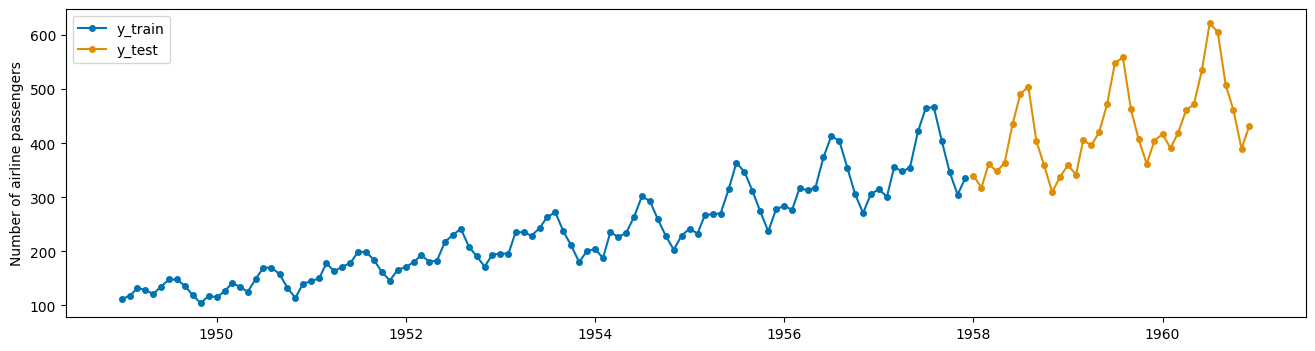

In [2]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y=y, test_size=0.25)
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])

##### Step 2: Configure the window splitter

In [3]:
window_length = 20

fh = ForecastingHorizon(range(1, 5))
cv = SingleWindowSplitter(window_length=window_length, fh=fh)

print(f"Number of Folds = {cv.get_n_splits(y)}")

Number of Folds = 1


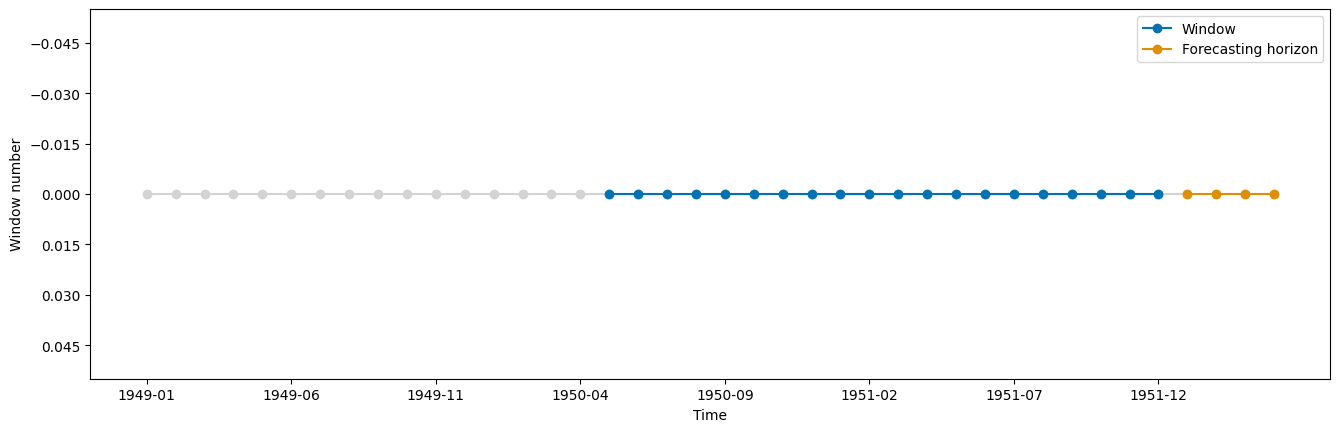

In [4]:
fig, ax = plot_windows(cv=cv, y=y_train[0:40])

#### Sliding window (or rolling origin)

- Training window of a fixed size
- The entire window (both **training** and **testing** sets) then _slides_ forward in time by a specified number of steps, and the process is repeated.

**Use Case**: This is particularly useful when you believe only the most recent history is relevant for predicting the future, which is common in systems that change over time (i.e., they exhibit **concept drift**).

In [5]:
from sktime.split import SlidingWindowSplitter

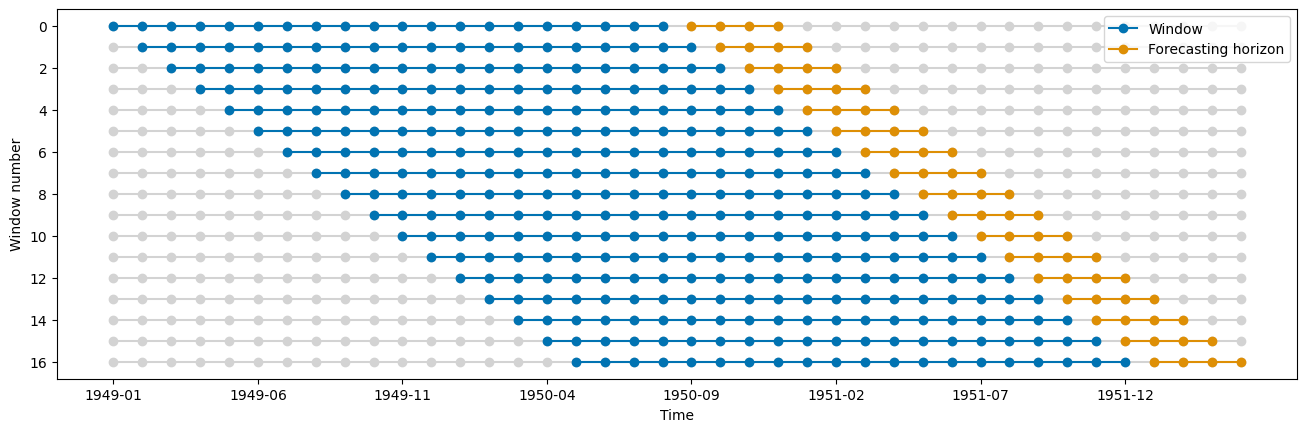

In [6]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)
fig, ax = plot_windows(cv=cv, y=y_train[0:40])

Some times, it can be useful to have an initial window of different size. This could be to provide more information on the first attempt:

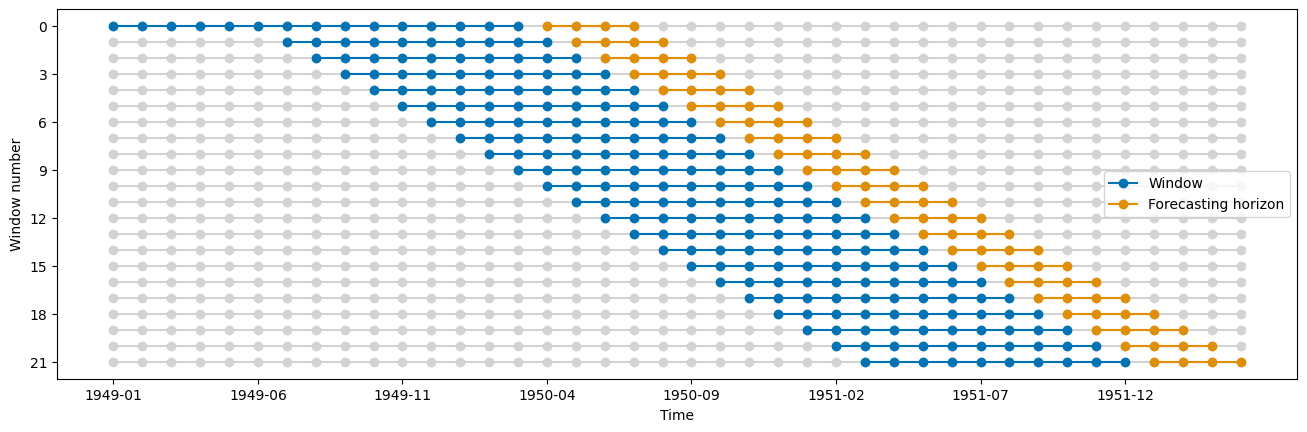

In [7]:
window_length = 10
cv = SlidingWindowSplitter(window_length=window_length, fh=fh, initial_window=15)
fig, ax = plot_windows(cv=cv, y=y_train[0:40])

#### Expanding Window

- Training window starts with an initial size and "expands" in each subsequent split to include all past data.
- The validation set still slides forward after each training set.

**Use Case**: This is appropriate when you believe all historical data is valuable for training the model and that the underlying patterns in the series are relatively stable over time.


In [8]:
from sktime.split import ExpandingWindowSplitter

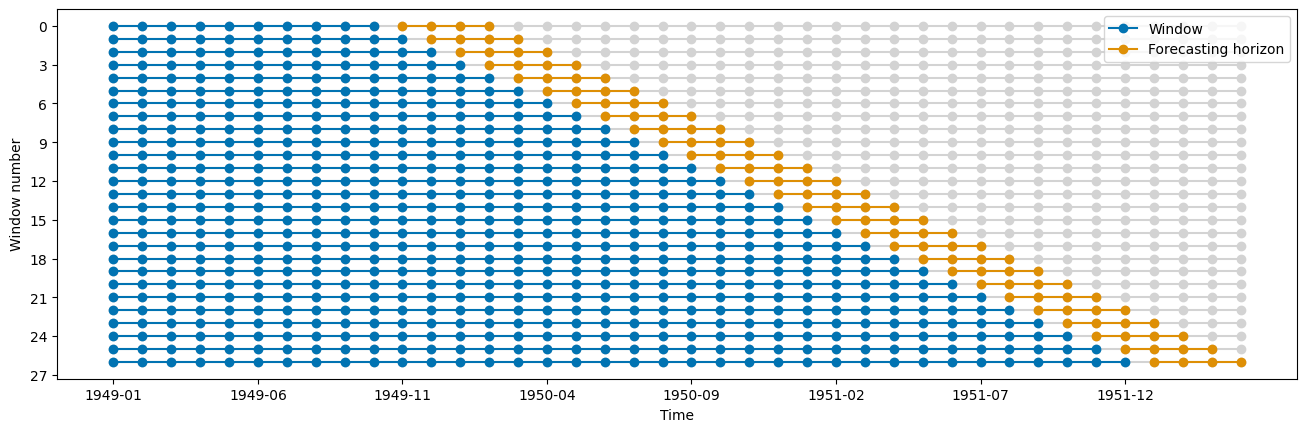

In [9]:
cv = ExpandingWindowSplitter(initial_window=window_length, fh=fh)
fig, ax = plot_windows(cv=cv, y=y_train[0:40])

#### Splits at cutoff points

- Manual control over where each split occurs.
- We provide the explicit list of **cutoff points**. 

**Use Case**: This is useful for non-standard evaluation scenarios, such as:

- **Event-based testing**: Creating splits right before and after significant external events (e.g., a policy change, a market shock, a product launch) to see how model performance is affected.
- **Milestone evaluation**: Evaluating model performance at specific, meaningful milestones, such as the end of every calendar year or fiscal quarter.
- **Reproducibility**: Ensuring different models are evaluated on the exact same, pre-determined data splits.


In [10]:
from sktime.split import CutoffSplitter

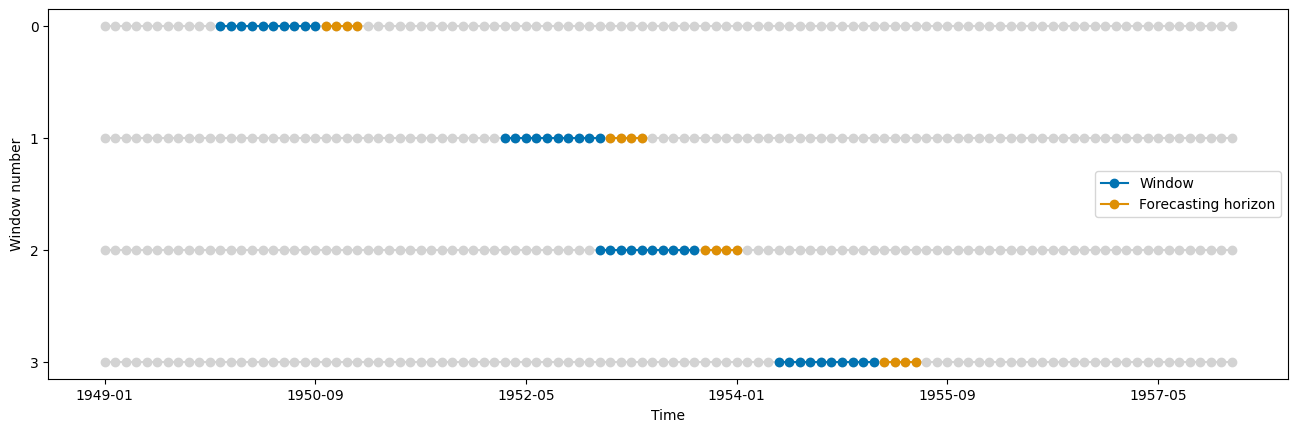

In [11]:
cutoffs = [20, 47, 56, 73]

cv = CutoffSplitter(cutoffs=cutoffs, window_length=window_length, fh=fh)

fig, ax = plot_windows(cv=cv, y=y_train)

### II.6.C. Performance metrics

Next step is to quantify how well our model's forecasts match the actual observed values. This is done using **performance metrics**.

We can group forecasting metrics into three main categories:

-  **Scale-dependent errors**: These are expressed in the same units as the original data. They are easy to interpret but cannot be used to compare models across different datasets with different scales.

-  **Percentage errors**: These are unit-free and express the error as a percentage. They are useful for comparing forecasts across different datasets but have significant drawbacks, especially when the data is close to or contains zero values.

-  **Scaled errors**: These are also unit-free and are now considered the gold standard for comparing forecast accuracy across series with different scales.


#### Scale-dependent metrics

-   **Mean Absolute Error (MAE)**: Calculates the average of the absolute differences between the forecast and the actual value. It's easy to understand and robust to outliers.
    $$
    \text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|
    $$
-   **Root Mean Squared Error (RMSE)**: Calculates the square root of the average of the squared errors. It penalizes large errors more heavily than MAE but is also more sensitive to outliers. The result is in the same unit as the original data.
    $$
    \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
    $$


#### Percentage-based metrics

-   **Mean Absolute Percentage Error (MAPE)**: One of the most common metrics, it expresses the average absolute error as a percentage of the actual values.
    $$
    \text{MAPE} = \frac{100\%}{n}\sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
    $$
    **Warning**: MAPE has significant limitations. It produces infinite or undefined values when the actual value $y_i$ is zero. It is also **asymmetric**, meaning it penalizes negative errors (over-forecasting) more heavily than positive errors (under-forecasting).

#### Scaled metrics


-   **Mean Absolute Scaled Error (MASE)**: This is often the recommended metric for comparing forecast accuracy across multiple time series. It scales the error based on the in-sample, one-step-ahead forecast error of a naive (random walk) model.
    $$
    \text{MASE} = \frac{\text{MAE}}{\frac{1}{T-m}\sum_{t=m+1}^{T} |y_t - y_{t-m}|}
    $$
    -   The numerator is the MAE of the model on the test set.
    -   The denominator is the MAE of a naive seasonal forecast on the training set (where $m$ is the seasonal period, or $m=1$ for non-seasonal data).
-   **Interpretation**:
    -   **MASE < 1**: The model is better than an in-sample naive forecast.
    -   **MASE > 1**: The model is worse than an in-sample naive forecast.

In [12]:
from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

In [13]:
y = load_airline()

forecaster = NaiveForecaster(strategy="last", sp=12)

cv_sliding = SlidingWindowSplitter(fh=12, window_length=60, step_length=12)

scorers = [
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteError(),
    MeanAbsoluteScaledError(),
]

In [14]:
evaluation_results = evaluate(
    forecaster=forecaster,
    y=y,
    cv=cv_sliding,
    scoring=scorers,
    return_data=False
)

In [15]:
evaluation_results

,test_MeanAbsolutePercentageError,test_MeanAbsoluteError,test_MeanAbsoluteScaledError,fit_time,pred_time,len_train_window,cutoff
0,0.122271,28.0,1.950413,0.001658,0.011545,60,1953-12
1,0.176259,49.0,2.885230,0.001445,0.008142,60,1954-12
2,0.091503,28.0,1.437772,0.001436,0.008053,60,1955-12
3,0.089286,30.0,1.339894,0.001428,0.007944,60,1956-12
4,0.002967,1.0,0.038562,0.001416,0.008090,60,1957-12
5,0.167901,68.0,2.245104,0.001427,0.008008,60,1958-12
6,0.062500,27.0,0.788224,0.001403,0.007907,60,1959-12


You can find many more metrics already implemented in `sktime` (or implement your own if needed)

In [16]:
from sktime.registry import all_estimators
all_estimators("metric", as_dataframe=True)

,name,object
0,AUCalibration,<class 'sktime.performance_metrics.forecasting...
1,CRPS,<class 'sktime.performance_metrics.forecasting...
2,ConstraintViolation,<class 'sktime.performance_metrics.forecasting...
3,DetectionCount,<class 'sktime.performance_metrics.detection._...
4,DirectedChamfer,<class 'sktime.performance_metrics.detection._...
5,DirectedHausdorff,<class 'sktime.performance_metrics.detection._...
6,EmpiricalCoverage,<class 'sktime.performance_metrics.forecasting...
7,GeometricMeanAbsoluteError,<class 'sktime.performance_metrics.forecasting...
8,GeometricMeanRelativeAbsoluteError,<class 'sktime.performance_metrics.forecasting...
9,GeometricMeanRelativeSquaredError,<class 'sktime.performance_metrics.forecasting...


### II.6.D. Grid search

Now we have all we need for a forecaster grid search.

In [17]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [18]:
y = load_airline()

y_train, y_test = temporal_train_test_split(y=y, test_size=25)

In [19]:
forecaster = ExponentialSmoothing()

NameError: name 'ExponentialSmoothing' is not defined

In [ ]:
fh = range(1, 25)
cv = ExpandingWindowSplitter(fh=fh)

In [ ]:
param_grid = {
    "trend": ["add", "mul"], 
    "sp": [1, 12, 24]
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanAbsolutePercentageError(),
)
gscv.fit(y_train, )

In [ ]:
best.cv_results_

In [ ]:
gscv.best_params_